In [1]:
from tools import SL2P
from tools import read_sentinel2_safe_image
from tools import dictionariesSL2P 
from matplotlib import pyplot as plt
import os,numpy
import rasterio
import os

### Initiation

In [2]:
variableName='LAI'
imageCollectionName="S2_SR"
fn = './testdata/S2B_MSIL2A_20230831T155829_N0509_R097_T18TVR_20230831T203613.SAFE' 

In [3]:
#### Input data Control ***-
if variableName not in dictionariesSL2P.make_net_options().keys():
    raise ValueError(('Supported vegetation valiables: %s'%(dictionariesSL2P.make_net_options().keys())))
if imageCollectionName not in dictionariesSL2P.make_net_options()[variableName].keys():
    raise ValueError(('Supported EO datasets: %s'%(dictionariesSL2P.make_net_options()[variableName].keys())))  
    
### Determine data resolution
RES=dictionariesSL2P.define_input_resolution()[imageCollectionName]

### 1- Read Sentinel-2 MSI/L2A image (.SAFE format)

In [4]:
s2=read_sentinel2_safe_image.read_s2(fn,res=RES)

Reading Sentinel-2 image


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s]


### 2- Prepare SL2P input data (11xNxM array): Surface reflectance (8- NxM layers) and acquisition geometry (3- NxM layers )

In [5]:
sl2p_inp=SL2P.prepare_sl2p_inp(s2,variableName,imageCollectionName)

Resample sun and view (sensor) angles
Scaling Sentinel-2 bands
Computing cosSZA, cosVZA and cosRAA
Selecting sl2p input bands
Done!


### 3- Run SL2P

In [6]:
varmap=SL2P.SL2P(sl2p_inp,variableName,imageCollectionName)

SL2PCCRS for DBF
To switch to SL2PCCRS for ENF use the appropriate function in tools\SL2PV0.py
SL2PCCRS for DBF
To switch to SL2PCCRS for ENF use the appropriate function in tools\SL2PV0.py
Generating sl2p input data flag
Run SL2P...
SL2P start: 2024-02-19 15:42:32.992220
SL2P end: 2024-02-19 15:42:43.202118
Generating sl2p output product flag
Done


### Export SL2P product

In [30]:
ofn=fn.replace('.SAFE',variableName+'.tif')
profile=s2['profile']
profile.update({'count':4,'dtype':'float32','driver':'GTiff'}) 
with rasterio.open(ofn,'w',**profile) as dst:
    dst.write(varmap[variableName],1)
    dst.write(varmap[variableName+'_uncertainty'],2)
    dst.write(varmap['sl2p_inputFlag'],3)
    dst.write(varmap['sl2p_outputFlag'],4)

### 4- Show results 

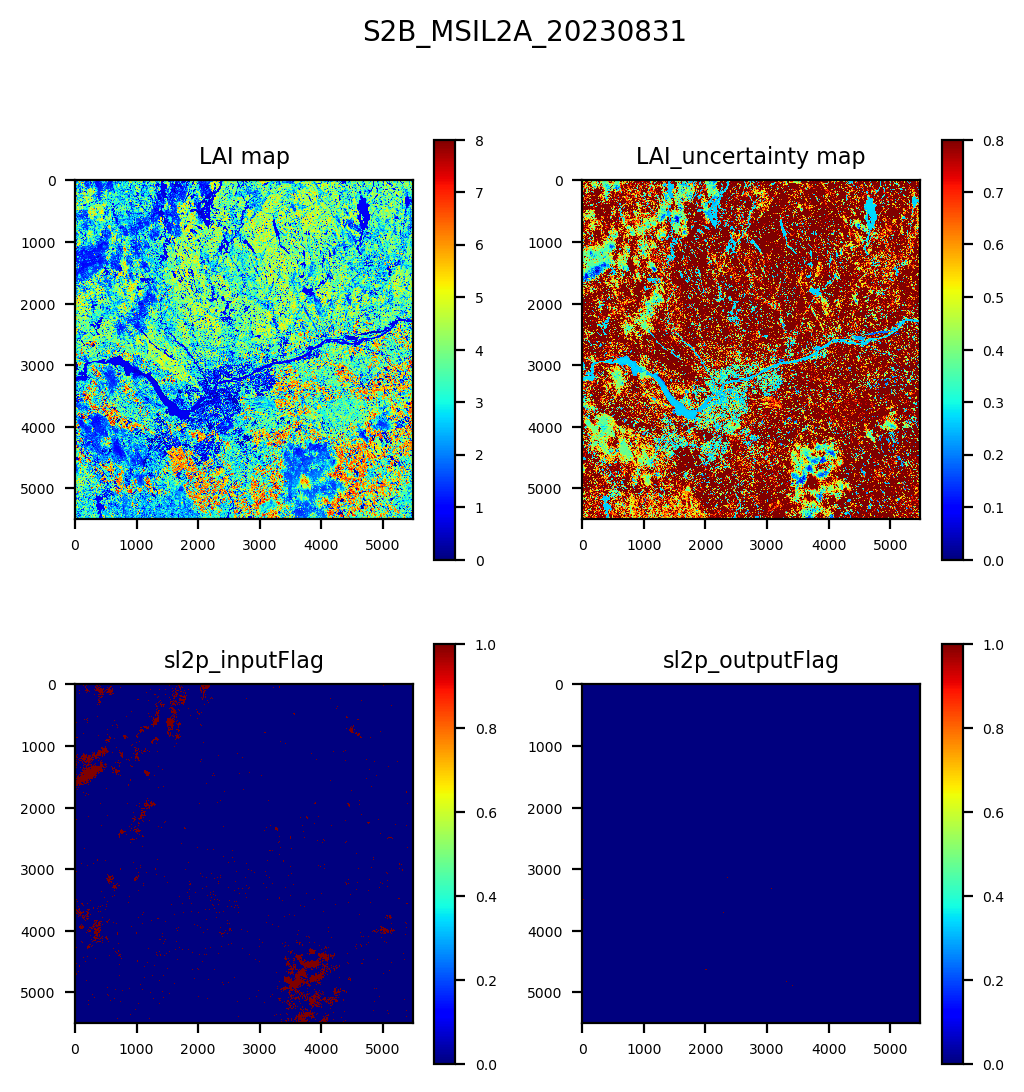

In [7]:
maxvar=dictionariesSL2P.make_outputParams()[variableName]['outputMax']
plt.rcParams.update({'font.size': 5})

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2,figsize=(6,6),dpi=200)
fig.suptitle(os.path.split(fn)[-1][:19],fontsize=10)

im1 = ax1.imshow(varmap[variableName],interpolation='nearest',vmin=0,vmax=maxvar,cmap='jet')
ax1.set_title(variableName+' map',fontsize=8)
fig.colorbar(im1, ax=ax1, orientation='vertical')

im2 = ax2.imshow(varmap[variableName+'_uncertainty'],interpolation='nearest',vmin=0,vmax=maxvar/10,cmap='jet')
ax2.set_title(variableName+'_uncertainty'+' map',fontsize=8)
fig.colorbar(im2, ax=ax2, orientation='vertical')

im3 = ax3.imshow(varmap['sl2p_inputFlag'],interpolation='nearest',vmin=0,vmax=1,cmap='jet')
ax3.set_title('sl2p_inputFlag',fontsize=8)
fig.colorbar(im3, ax=ax3, orientation='vertical')

im4 = ax4.imshow(varmap['sl2p_outputFlag'],interpolation='nearest',vmin=0,vmax=1,cmap='jet')
ax4.set_title('sl2p_outputFlag',fontsize=8)
fig.colorbar(im4, ax=ax4, orientation='vertical')


### 5- Mask cloud, shadow, water ...

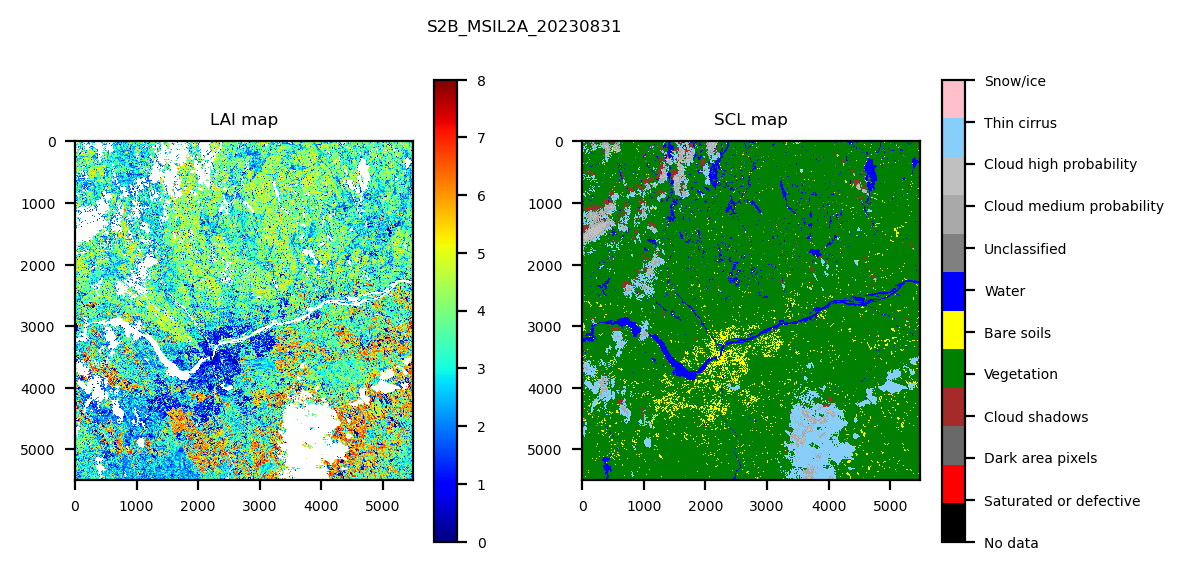

In [8]:
# Mask cloud, shadow, ....
from matplotlib.colors import ListedColormap
cmap =  ListedColormap(["black","red","dimgray","brown","green","yellow","Blue","gray","darkgray","silver","lightskyblue","pink"])
mask=numpy.where((s2['SCL']==4) | (s2['SCL']==5), 1, numpy.nan)

plt.rcParams.update({'font.size': 5})
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(6,3),dpi=200)
fig.suptitle(os.path.split(fn)[-1][:19])

im1 = ax1.imshow(varmap[variableName]*mask,interpolation='nearest',vmin=0,vmax=maxvar,cmap='jet')
ax1.set_title(variableName+' map')
fig.colorbar(im1, ax=ax1, orientation='vertical')

im2 = ax2.imshow(s2['SCL'],interpolation='nearest',vmin=0,vmax=11,cmap=cmap)
ax2.set_title('SCL map')
cbar=fig.colorbar(im2, ax=ax2, ticks=numpy.linspace(0, 11, 12),orientation='vertical')
cbar.ax.set_yticklabels(['No data','Saturated or defective','Dark area pixels','Cloud shadows','Vegetation','Bare soils','Water','Unclassified','Cloud medium probability','Cloud high probability','Thin cirrus','Snow/ice']);